## Approach

1. Identify available dates and temporal frequency of observations for the given collection using the GHGC API `/stac` endpoint. The collection processed in this notebook is the Wetland Methane Emissions, LPJ-wsl Model data product.
2. Pass the STAC item into the raster API `/stac/tilejson.json `endpoint.
3. Using `folium.plugins.DualMap`, visualize two tiles (side-by-side), allowing time point comparison.
4. After the visualization, perform zonal statistics for a given polygon.

   

## About the Data

Methane (CH₄) emissions from wetlands are estimated to be the largest natural source of methane in the global CH₄ budget, contributing to roughly one third of the total of natural and anthropogenic emissions. Wetland CH₄ is produced by microbes breaking down organic matter in the oxygen deprived environment of inundated soils. Due to limited data availability, the details of the role of wetland CH₄ emissions has thus far been underrepresented. Using the Wald Schnee und Landschaft version (LPJ-wsl) of the Lund-Potsdam-Jena Dynamic Global Vegetation Model (LPJ-DGVM) global CH₄ emissions from wetlands are estimated at 0.5 x 0.5 degree resolution by simulating wetland extent and using characteristics of these inundated areas, such as soil moisture, temperature, and carbon content, to estimate CH₄ quantities emitted into the atmosphere. Highlighted areas displayed in this dataset show concentrated methane sources from tropical and high latitude ecosystems. The LPJ-wsl Wetland Methane Emissions data product presented here consists of global daily and monthly model estimates of terrestrial wetland CH₄ emissions from 1980 - 2021. These data are regularly used in conjunction with NASA’s Goddard Earth Observing System (GEOS) model to simulate the impact of wetlands and other methane sources on atmospheric methane concentrations, to compare against satellite and airborne data, and to improve understanding and prediction of wetland emissions.

## Flow of Workshop
1. Reading data 
    1. Read LPJ dataset from STAC
    2. Read subset of Merra-2 (few variables) data using credentials
    3. Creating different region of interest
2. Statistical Analysis
    1. Select the region and create time series of total emission in the region
    Note we will have line chart for two different years to show inter annual variability
    2. Create dual folium map to show visual comparision
    3. Plot monthly mean and climate mean using merra-2 data for same region of interest
    4. Plot time series for the following data and time period to interpret the results:
        a. 2020, 2021 - LPJ monthly emissions
        b. 2020, 2021 - Merra 2 T2M monthly anomaly
        c. 2020, 2021 - Total precipitation rate

Datasets to be used
1. Monthly LPJ Wetland CH4 Emissions
2. Monthly MERRA-2 Precipitation RateDataset: MERRA2_400.tavgM_2d_flx_Nx
Variable: ‘PRECTOT’
https://disc.gsfc.nasa.gov/datasets/M2TMNXFLX_5.12.4/summary

3. Monthly MERRA-2 Surface Soil MoistureDataset: MERRA2_400.tavgM_2d_lnd_Nx
Variable: ‘SFMC’
Long-term mean variable: ‘GWETTOP’
https://disc.gsfc.nasa.gov/datasets/M2TMNXLND_5.12.4/summary

4. Monthly MERRA-2 T2MDataset: MERRA2_400.instM_2d_asm_Nx
Variable: ‘T2M’
https://disc.gsfc.nasa.gov/datasets/M2IMNXASM_5.12.4/summary

5. MERRA-2 Long-Term MeansMERRA2.tavgC_2d_ltm_Nx
https://disc.gsfc.nasa.gov/datasets/M2TCNXLTM_1/summary

Use case to be discussed:
1. Midwest floods in 2019
2. Pick events of interest

# Installing the Required Libraries
Required libraries are pre-installed on the GHG Center Hub. If you need to run this notebook elsewhere, please install them with this line in a code cell:

%pip install requests, folium, rasterstats, pystac_client, pandas, matplotlib

## Querying the STAC API

In [ ]:
import requests
import folium
import folium.plugins
from folium import Map, TileLayer 
from pystac_client import Client 
import pandas as pd
import matplotlib.pyplot as plt
import branca.colormap as cm
import geopandas
from pyproj import Geod
from shapely import wkt
import seaborn as sns

In [ ]:
# Provide STAC and RASTER API endpoints
STAC_API_URL = "http://ghg.center/api/stac"
RASTER_API_URL = "https://ghg.center/api/raster"

# Please use the collection name similar to the one used in STAC collection.

# Name of the collection for wetland methane monthly emissions. 
collection_name = "lpjwsl-wetlandch4-monthgrid-v1"

In [ ]:
# Fetching the collection from STAC collections using appropriate endpoint.
collection = requests.get(f"{STAC_API_URL}/collections/{collection_name}").json()
collection

Examining the contents of our `collection` under `summaries`, we see that the data is available from January 1980 to may 2021. By looking at `dashboard: time density`, we can see that these observations are collected monthly.

In [ ]:
def get_item_count(collection_id):
    count = 0
    items_url = f"{STAC_API_URL}/collections/{collection_id}/items"

    while True:
        response = requests.get(items_url)

        if not response.ok:
            print("error getting items")
            exit()

        stac = response.json()
        count += int(stac["context"].get("returned", 0))
        next = [link for link in stac["links"] if link["rel"] == "next"]

        if not next:
            break
        items_url = next[0]["href"]

    return count

In [ ]:
# Check total number of items available
number_of_items = get_item_count(collection_name)
items = requests.get(f"{STAC_API_URL}/collections/{collection_name}/items?limit={number_of_items}").json()["features"]
print(f"Found {len(items)} items")

In [ ]:
# Examining the first item in the collection
items[0]

Below, we enter minimum and maximum values to provide our upper and lower bounds in `rescale_values.`

In [65]:
rescale_values = {'max': 2.0, 'min': 0.0}

## Exploring Changes in Methane (CH4) Emission Levels Using the Raster API

In this notebook, we will explore the temporal impacts of methane emissions. We will visualize the outputs on a map using `folium`.


In [ ]:
# To access the year value from each item more easily, this will let us query more explicity by year and month (e.g., 2020-02)
items = {item["properties"]["datetime"][:7]: item for item in items} 
asset_name = 'ch4-wetlands-emissions'

In [ ]:
aoi = [-95.9,-87.50,28.7,33.5]
louisiana_aoi = {
    "type": "Feature",
    "properties": {},
    "geometry": {
        "coordinates": [
            [
                [aoi[0], aoi[2]],
                [aoi[0], aoi[3]],
                [aoi[1], aoi[3]],
                [aoi[1],aoi[2]],
                [aoi[0], aoi[2]]
            ]
        ],
        "type": "Polygon",
    },
}


Now, we will pass the item id, collection name, and `rescaling_factor` to the `Raster API` endpoint. We will do this twice, once for may 2001 and again for may 2021, so we can visualize each event independently.

In [95]:
color_map = "magma" # select the color ramp from matplotlib library.
may_2020_tile = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items['2001-05']['collection']}&item={items['2020-05']['id']}"
    "&assets=ch4-wetlands-emissions"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}"
).json()
may_2020_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://ghg.center/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=lpjwsl-wetlandch4-monthgrid-v1&item=lpjwsl-wetlandch4-monthgrid-v1-202005&assets=ch4-wetlands-emissions&color_formula=gamma+r+1.05&colormap_name=magma&rescale=0.0%2C2.0'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 180.0, 90.0],
 'center': [0.0, 0.0, 0]}

In [67]:
may_2021_tile = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items['2021-05']['collection']}&item={items['2021-05']['id']}"
    "&assets=ch4-wetlands-emissions"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}", 
).json()
may_2021_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://ghg.center/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=lpjwsl-wetlandch4-monthgrid-v1&item=lpjwsl-wetlandch4-monthgrid-v1-202105&assets=ch4-wetlands-emissions&color_formula=gamma+r+1.05&colormap_name=magma&rescale=0.0%2C2.0'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 180.0, 90.0],
 'center': [0.0, 0.0, 0]}

## Visualizing CH₄ Emissions


In [82]:
# We will import folium to map and folium.plugins to allow side-by-side mapping
# Set initial zoom and center of map for CH₄ Layer
# Centre of map [latitude,longitude]
from folium.plugins import MousePosition
map_ = folium.Map(location=(30,-90), zoom_start=6)

# May 2001
map_layer_2001 = TileLayer(
    tiles=may_2020_tile["tiles"][0],
    attr="GHG",
    opacity=0.5,
)


# May 2021
map_layer_2021 = TileLayer(
    tiles=may_2021_tile["tiles"][0],
    attr="GHG",
    opacity=0.5,
)
sbs = folium.plugins.SideBySideLayers(layer_left=map_layer_2001, layer_right=map_layer_2021)
map_layer_2001.add_to(map_)
map_layer_2021.add_to(map_)
folium.GeoJson(louisiana_aoi, name="louisiana, USA").add_to(map_)
sbs.add_to(map_)
MousePosition().add_to(map_)
# visualising the map
map_



In [ ]:
# The bounding box should be passed to the geojson param as a geojson Feature or FeatureCollection
def generate_stats(item, geojson):
    result = requests.post(
        f"{RASTER_API_URL}/cog/statistics",
        params={"url": item["assets"]["ch4-wetlands-emissions"]["href"]},
        json=geojson,
    ).json()
    return {
        **result["properties"],
        "datetime": item["properties"]["datetime"],
    }

With the function above, we can generate the statistics for the area of interest.

In [ ]:
# around 5 mins 
stats = [generate_stats(item, louisiana_aoi) for item in items]

In [ ]:
stats

In [ ]:

def clean_stats(stats_json) -> pd.DataFrame:
    df = pd.json_normalize(stats_json)
    df.columns = [col.replace("statistics.b1.", "") for col in df.columns]
    df["date"] = pd.to_datetime(df["datetime"])
    return df


df = clean_stats(stats)
df.head(5)

In [ ]:
df_2020_2021 = df[(df['date'].dt.year == 2020) | (df['date'].dt.year == 2021)]
df_2020_2021['year'] = pd.to_datetime(df_2020_2021['datetime']).dt.year
df_2020_2021['month'] = pd.to_datetime(df_2020_2021['datetime']).dt.month
df_2020_2021

## Visualizing the Data as a Time Series
We can now explore the wetland methane emissions time series (January 1980 – may 2021) available for the Dallas, Texas area of the U.S. We can plot the data set using the code below:

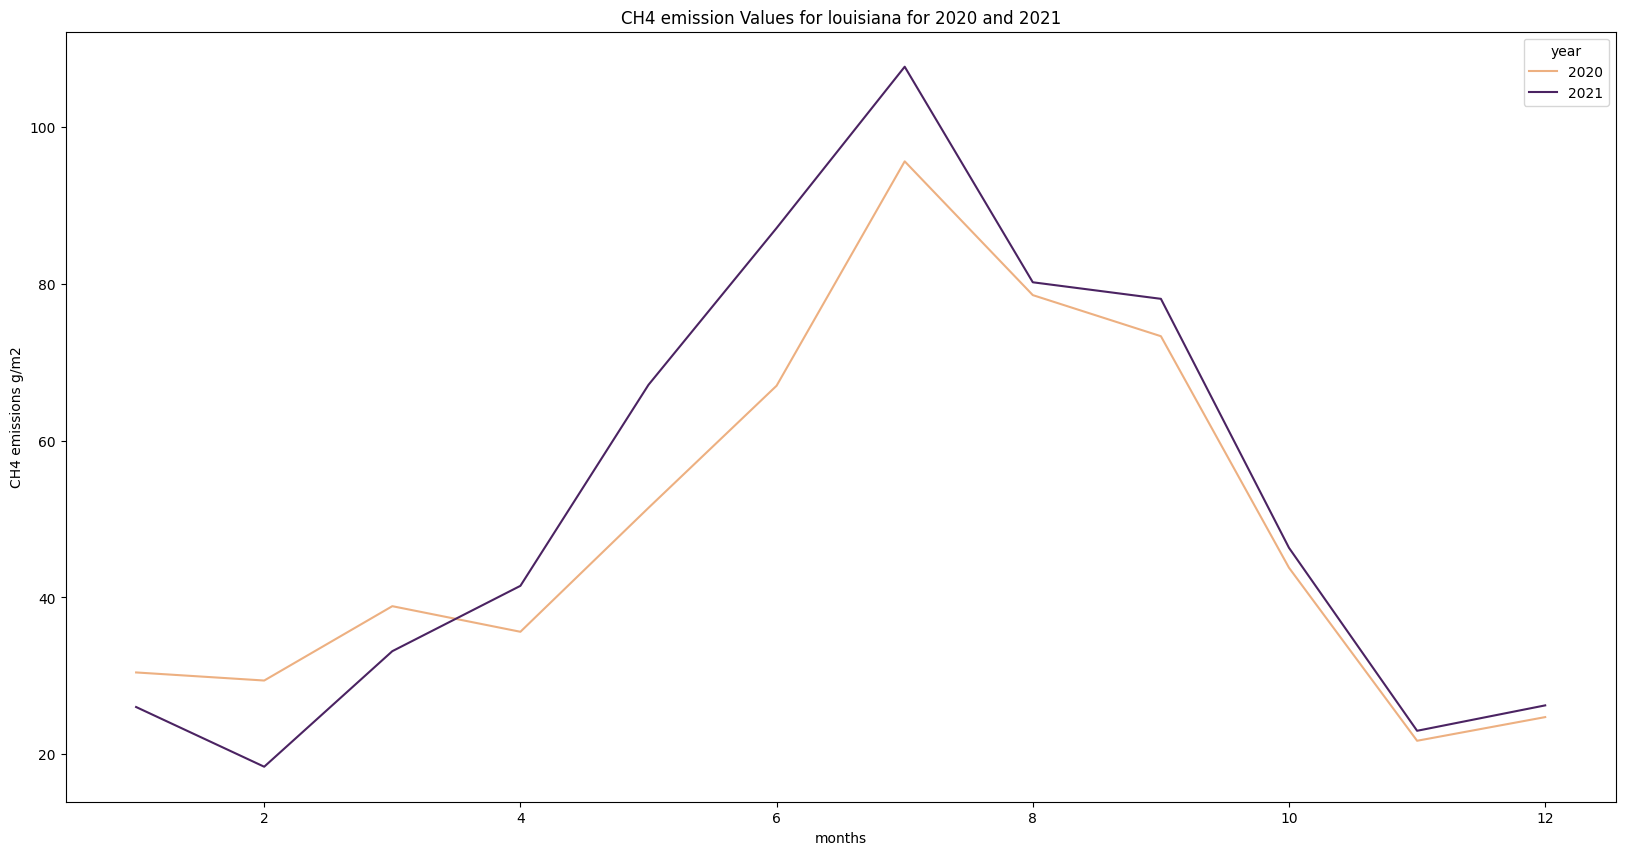

In [99]:
fig = plt.figure(figsize=(20, 10))

sns.lineplot(
    df_2020_2021,
    x = 'month', 
    y = 'sum',
    hue= 'year',
    palette='flare'
)

# plt.legend()
plt.xlabel("months")
plt.ylabel("CH4 emissions g/m2")
plt.title("CH4 emission Values for louisiana for 2020 and 2021")

# We will import folium to map and folium.plugins to allow side-by-side mapping
# Set initial zoom and center of map for CH₄ Layer
# Centre of map [latitude,longitude]

colormap = cm.LinearColormap(colors = ['#2c115f','#721f81','#b73779','#f1605d','#feb078'], vmin = 0, vmax = 2 )
colormap.caption = 'g CH₄/m²/day'

may_2021_tile = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items['2021-05']['collection']}&item={items['2021-05']['id']}"
    "&assets=ch4-wetlands-emissions"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}", 
).json()
may_2021_tile
june_2021_tile = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items['2021-06']['collection']}&item={items['2021-06']['id']}"
    "&assets=ch4-wetlands-emissions"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}", 
).json()
june_2021_tile
july_2021_tile = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items['2021-07']['collection']}&item={items['2021-07']['id']}"
    "&assets=ch4-wetlands-emissions"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}", 
).json()
july_2021_tile

map_ = folium.Map(location=(30,-90), zoom_start=5)

# May 2001
map_layer_202105 = TileLayer(
    tiles=may_2020_tile["tiles"][0],
    attr="GHG",
    opacity=0.5,
    name='May'
)
map_layer_202105.add_to(map_)

# May 2021
map_layer_202106 = TileLayer(
    tiles=june_2021_tile["tiles"][0],
    attr="GHG",
    opacity=0.5,
    name='June'
)
map_layer_202106.add_to(map_)

map_layer_202107 = TileLayer(
    tiles=july_2021_tile["tiles"][0],
    attr="GHG",
    opacity=0.5,
    name='July'
)
map_layer_202107.add_to(map_)

folium.GeoJson(louisiana_aoi, name="louisiana, USA").add_to(map_)
folium.LayerControl(collapsed=False,position='bottomleft').add_to(map_)

svg_style = '<style>svg#legend {font-size: 14px; background-color: white;}</style>'
map_.get_root().header.add_child(folium.Element(svg_style))
map_.add_child(colormap)
# visualising the map
map_

In [ ]:
def monthly_timeseries(year,focus,param,anomaly):
    labels = []
    cmap = plt.get_cmap('gnuplot') 
    colors = cmap(np.linspace(0,1,len(param)))
    for i,p in enumerate(param):
        if 'LPJ' in p:
            ts = get_lpj_timeseries(year,focus,p)
        elif 'MERRA' in p:
            ts = get_merra2_timeseries(year,focus,p,anomaly)
            
        if i == 0:
            fig = plt.figure(figsize=(6,3))
            ax = fig.add_subplot(111)

        #breakpoint()
        try:
            ax.plot(
                list(range(0,12)),
                ts['box_totals'],
                linestyle='-',
                linewidth=2,
                color=colors[i],
                markersize=4,
                marker='o',
                label=p
            )
        except ValueError:
            print('Double check that you have all twelve months of MERRA-2 data downloaded!')
            print(params[p]['dir'])
            breakpoint()

        #   Construct plot title
        title = '%s\n%s Mean Monthly %s'%(focus,year,p)
        if anomaly:
           title+=' Anomaly' 
        if 'LPJ' in p:
            title = title.replace('Mean','Total')
        plt.title(title)
        
        plt.xticks(list(range(0,12)))
        ax.set_xticklabels(ts['month_labels'],rotation=40,ha='right')


        if p == param[-1]:
            if i > 0:
                ax.legend(loc='best')
                nickname = '_'.join(params[p]['nickname'] for p in params)
                savename = '%s/box_summed_%s_%s_%s.png'% \
                    (savedir,nickname,year,focus)
            else:
                nickname = params[p]['nickname']
                savename = '%s/%s/%s/box_summed_%s_%s_%s.png'% \
                    (savedir,nickname,focus,nickname,year,focus)
            if anomaly:
                ax.plot(list(range(-1,13)),np.zeros(14),linewidth=0.4)
                savename = savename.replace('.png','_Anomaly.png')
            ax.set_xlim(-1,12)
            ax.set_ylim(-4e-5,4e-5)     #   manual per parameter
            print('Saving to '+savename)
            plt.figure(1).savefig(savename,dpi=300,bbox_inches='tight')

    return ts 
    
    

def monthly_heatmaps(year,focus,p,anomaly):
    if 'LPJ' in p:
        ts = get_lpj_timeseries(year,focus,p)
    if 'MERRA-2' in p:
        ts = get_merra2_timeseries(year,focus,p,anomaly)
    
    for t in range(0,len(ts['month_labels'])):    #   monthly data
        plt.close()
    
        #   Construct plot title
        title = '%s\n%s %s'% \
            (datetime(int(year),t+1,1).strftime('%B %Y'),focus,p)
        #   Construct file savename
        savename = savedir+'%s/%s/%s_%s_%s_%s.png'% \
            (params[p]['nickname'],
            focus,
            params[p]['nickname'],
            focus,
            year,
            datetime(int(year),t+1,1).strftime('%m')
            )

        if anomaly:
            savename = savename.replace('.png','_Anomaly.png')
            title+=' Anomaly'
            cmap = 'RdBu_r'
        else:
            cmap = params[p]['cmap']
    
        #   vmin and vmax currently set manually per parameter
        heatmap(
            ts['lon'],
            ts['lat'][:],
            ts['month_fields'][t],
            colbar_label=ts['units'],
            boundaries=boundaries[focus],
            cmap=cmap,
            #vmin = 0,
            #vmax = 0.0025,
            vmin = -4e-5,
            vmax = 4e-5,
            #vmin = 260,
            #vmax = 315,
            #vmin = 0,
            #vmax = np.nanmean(ts['month_fields'])+2.5*np.nanstd(ts['month_fields']),
            #vmin = -4*np.nanstd(ts['month_fields']),
            #vmax = 4*np.nanstd(ts['month_fields']),
            **{'title':title,'savename':savename}
        )
#   save(year)

### Things to be added
Plot for variable

## Summary
In this notebook, we have successfully explored, analyzed, and visualized the STAC collection for wetland methane emissions.